In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import re

from nltk import word_tokenize
from nltk.corpus import stopwords
from nltk.stem import PorterStemmer
from sklearn.model_selection import train_test_split
from sklearn.naive_bayes import MultinomialNB
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score, confusion_matrix
from wordcloud import WordCloud, STOPWORDS
from sklearn.metrics import classification_report
from sklearn.pipeline import Pipeline
from sklearn.linear_model import LogisticRegression
from sklearn.linear_model import SGDClassifier
from sklearn import svm
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import GridSearchCV
from sklearn.metrics import classification_report
from sklearn.feature_extraction.text import TfidfTransformer
from sklearn.ensemble import RandomForestClassifier
from sklearn.neural_network import MLPClassifier
import tensorflow as tf
from sklearn.model_selection import StratifiedShuffleSplit, StratifiedKFold
from tensorflow.keras.preprocessing.text import Tokenizer
from tensorflow.keras.layers import Embedding, LSTM, Dense, Bidirectional, GRU
from tensorflow.keras import datasets, layers, models, preprocessing

from nltk import word_tokenize
from nltk.corpus import stopwords
from nltk.stem.snowball import SnowballStemmer

from sklearn.feature_extraction.text import CountVectorizer
from sklearn.feature_extraction.text import TfidfVectorizer
import sklearn.cluster as cluster
from sklearn.preprocessing import LabelBinarizer, LabelEncoder
from sklearn.metrics import confusion_matrix
from sklearn.model_selection import KFold
from sklearn.model_selection import cross_val_score

from tensorflow import keras
from keras.models import Sequential
from keras.layers import Dense, Activation, Dropout
from keras.preprocessing import text, sequence
from keras import utils

from statistics import mean

import time
%matplotlib inline
%%time
import plotly.offline as py
import plotly.graph_objs as go
from plotly.offline import init_notebook_mode
init_notebook_mode(connected=True)
from plotly import tools

UsageError: Line magic function `%%time` not found.


# Insert CSV File

In [2]:
df = pd.read_csv('mbti_1.csv')
df.head()

,type,posts
0,INFJ,'http://www.youtube.com/watch?v=qsXHcwe3krw|||...
1,ENTP,'I'm finding the lack of me in these posts ver...
2,INTP,'Good one _____ https://www.youtube.com/wat...
3,INTJ,"'Dear INTP, I enjoyed our conversation the o..."
4,ENTJ,'You're fired.|||That's another silly misconce...


In [3]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 8675 entries, 0 to 8674
Data columns (total 2 columns):
 #   Column  Non-Null Count  Dtype 
---  ------  --------------  ----- 
 0   type    8675 non-null   object
 1   posts   8675 non-null   object
dtypes: object(2)
memory usage: 135.7+ KB


In [4]:
# Display counts of types of personalities
df["type"].value_counts()

INFP    1832
INFJ    1470
INTP    1304
INTJ    1091
ENTP     685
ENFP     675
ISTP     337
ISFP     271
ENTJ     231
ISTJ     205
ENFJ     190
ISFJ     166
ESTP      89
ESFP      48
ESFJ      42
ESTJ      39
Name: type, dtype: int64

/Library/Frameworks/Python.framework/Versions/3.8/lib/python3.8/site-packages/seaborn/_decorators.py:36: FutureWarning: Pass the following variables as keyword args: x, y. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  warnings.warn(


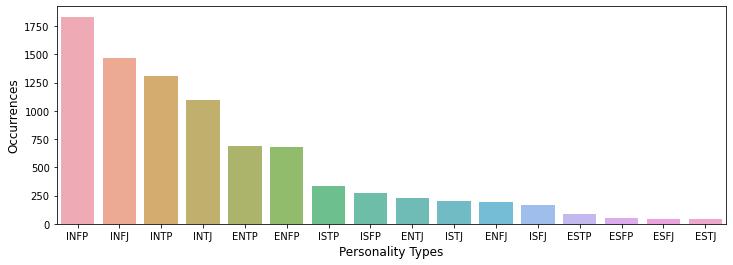

In [5]:
types = df['type'].value_counts()

plt.figure(figsize=(12,4))
sns.barplot(types.index, types.values, alpha=0.8)
plt.ylabel('Occurrences', fontsize=12)
plt.xlabel('Personality Types', fontsize=12)
plt.show()

#### The occurance of posts by each personality type is not well balanced.

In [6]:
# Let's remove hyperlinks in posts
df['posts'] = df['posts'].replace(to_replace=r'https?:\/\/.*[\r\n]*',value='',regex=True)
df.head()

,type,posts
0,INFJ,'
1,ENTP,'I'm finding the lack of me in these posts ver...
2,INTP,'Good one _____
3,INTJ,"'Dear INTP, I enjoyed our conversation the o..."
4,ENTJ,'You're fired.|||That's another silly misconce...


### Wordclouds

Let's have a look at some wordclouds..

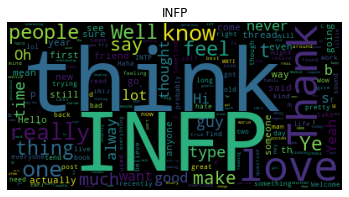

In [7]:
wordcloud = WordCloud().generate(df[df['type']=='INFP']['posts'].to_string())
plt.title("INFP")
plt.axis("off")
plt.imshow(wordcloud)

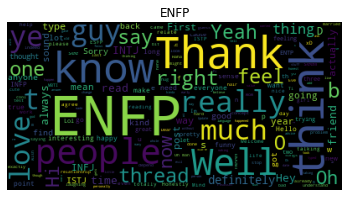

In [8]:
wordcloud = WordCloud(stopwords = STOPWORDS).generate(df[df['type']=='ENFP']['posts'].to_string())
plt.title("ENFP")
plt.axis("off")
plt.imshow(wordcloud)

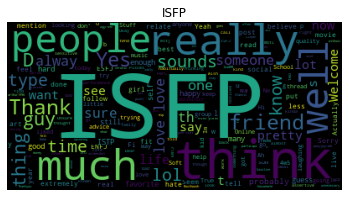

In [9]:
wordcloud = WordCloud(stopwords = STOPWORDS).generate(df[df['type']=='ISFP']['posts'].to_string())
plt.title("ISFP")
plt.axis("off")
plt.imshow(wordcloud)

# Preprocess data

In [11]:
stop_words = stopwords.words("english")
stop_words += ['intj', 'intp', 'entj', 'entp', 'infj', 'infp', 'enfj', 'enfp', 'istj', 'isfj', 'estj', 'esfj', 'istp', 'isfp', 'estp', 'esfp']

def preprocess_data(post):
    # lowercase post
    post = post.lower()
    # replace unwanted symbols with spaces
    post = re.compile('[/(){}\[\]\|@,;]').sub(' ', post) 
    # replace non alphabeltic charecters with spaces
    post = re.compile('[^0-9a-z #+_]').sub('', post)
    # Delete stopword from posts
    post = ' '.join(word for word in post.split() if word not in stop_words) 
    return post
    
df['posts'] = df['posts'].apply(preprocess_data)
df.head()

,type,posts
0,INFJ,
1,ENTP,im finding lack posts alarming sex boring posi...
2,INTP,good one _____
3,INTJ,dear enjoyed conversation day esoteric gabbing...
4,ENTJ,youre fired thats another silly misconception ...


In [12]:
stemmer = SnowballStemmer('english')
class StemmedCountVectorizer(CountVectorizer):
    def build_analyzer(self):
        analyzer = super(StemmedCountVectorizer, self).build_analyzer()
        return lambda doc: ([stemmer.stem(w) for w in analyzer(doc)])

# vectorizer = StemmedCountVectorizer(min_df=3, analyzer="word")

# One Hot Encoding

In [13]:
le = LabelEncoder() 
df['type']= le.fit_transform(df['type']) 
df.head()

,type,posts
0,8,
1,3,im finding lack posts alarming sex boring posi...
2,11,good one _____
3,10,dear enjoyed conversation day esoteric gabbing...
4,2,youre fired thats another silly misconception ...


# Split Data for Training and Testing

In [14]:
X = df.posts
y = df.type
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, train_size=0.8, random_state=1234, shuffle = True, stratify= y)

In [15]:
print(X_train.shape)
print(y_train.shape)

(6940,)
(6940,)


## Naive Bayes

In [16]:
person_types = ['INFP','INFJ','INTP','INTJ','ENTP','ENFP','ISTP','ISFP','ENTJ','ISTJ','ENFJ','ISFJ','ESTP','ESFP','ESFJ','ESTJ' ]   

In [17]:
# Use term frequency-inverse document frequency to convert test to a matrix of tf-idf features
nb = Pipeline([('vect', StemmedCountVectorizer(analyzer="word")),
               ('tfidf', TfidfTransformer(smooth_idf=True,use_idf=True)),
               ('clf', MultinomialNB()),
              ])
nb.fit(X_train, y_train)

y_pred = nb.predict(X_test)

print('accuracy %s' % accuracy_score(y_pred, y_test))
print(classification_report(y_test, y_pred,target_names=person_types, zero_division=0))

accuracy 0.2138328530259366
              precision    recall  f1-score   support

        INFP       0.00      0.00      0.00        38
        INFJ       0.00      0.00      0.00       135
        INTP       0.00      0.00      0.00        46
        INTJ       0.00      0.00      0.00       137
        ENTP       0.00      0.00      0.00         8
        ENFP       0.00      0.00      0.00        10
        ISTP       0.00      0.00      0.00         8
        ISFP       0.00      0.00      0.00        18
        ENTJ       0.57      0.01      0.03       294
        ISTJ       0.21      1.00      0.35       367
        ENFJ       0.00      0.00      0.00       218
        ISFJ       0.00      0.00      0.00       261
        ESTP       0.00      0.00      0.00        33
        ESFP       0.00      0.00      0.00        54
        ESFJ       0.00      0.00      0.00        41
        ESTJ       0.00      0.00      0.00        67

    accuracy                           0.21      173

## Logisitic Regression

In [22]:
#(ngram_range=(1,2)
logreg = Pipeline([('vect', StemmedCountVectorizer(analyzer="word")),
                ('tfidf', TfidfTransformer()),
                ('clf', LogisticRegression(n_jobs=1, C=1e5, max_iter = 1000)),
               ])
logreg.fit(X_train, y_train)

y_pred = logreg.predict(X_test)


print('accuracy %s' % accuracy_score(y_pred, y_test))
print(classification_report(y_test, y_pred,target_names=person_types, zero_division=0))

/Library/Frameworks/Python.framework/Versions/3.8/lib/python3.8/site-packages/sklearn/linear_model/_logistic.py:762: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


accuracy 0.41152737752161384
              precision    recall  f1-score   support

        INFP       0.36      0.21      0.27        38
        INFJ       0.42      0.37      0.40       135
        INTP       0.27      0.13      0.18        46
        INTJ       0.33      0.31      0.32       137
        ENTP       0.00      0.00      0.00         8
        ENFP       0.00      0.00      0.00        10
        ISTP       0.00      0.00      0.00         8
        ISFP       0.50      0.17      0.25        18
        ENTJ       0.44      0.45      0.44       294
        ISTJ       0.43      0.59      0.49       367
        ENFJ       0.41      0.47      0.44       218
        ISFJ       0.42      0.46      0.44       261
        ESTP       0.62      0.15      0.24        33
        ESFP       0.26      0.13      0.17        54
        ESFJ       0.48      0.24      0.32        41
        ESTJ       0.31      0.19      0.24        67

    accuracy                           0.41      17

In [ ]:
# # Cross validation procedure
# cv = KFold(n_splits=10, random_state=1, shuffle=True)

# logreg = Pipeline([('vect', StemmedCountVectorizer(analyzer="word")),
#                 ('tfidf', TfidfTransformer()),
#                 ('clf', LogisticRegression(n_jobs=1, C=1e5, max_iter = 100)),
#                ])
# logreg.fit(X_train, y_train)

# y_pred = logreg.predict(X_test)

# # evaluate model
# scores = cross_val_score(logreg, X, y, scoring='accuracy', cv=cv, n_jobs=-1)
# # report performance
# print('Accuracy: %.3f (%.3f)' % (mean(scores), std(scores)))
# print('accuracy %s' % accuracy_score(y_pred, y_test))
# print(classification_report(y_test, y_pred,target_names=person_types, zero_division=0))

# Stochastic Gradient Descent

In [21]:
sgd = Pipeline([('vect', StemmedCountVectorizer(analyzer="word")),
                ('tfidf', TfidfTransformer()),
                ('clf', SGDClassifier(loss='hinge', penalty='l2',alpha=1e-3, random_state=42, max_iter=50, tol=None)),
               ])
sgd.fit(X_train, y_train)

y_pred = sgd.predict(X_test)

print('accuracy %s' % accuracy_score(y_pred, y_test))
print(classification_report(y_test, y_pred,target_names=person_types, zero_division=0))

accuracy 0.43573487031700286
              precision    recall  f1-score   support

        INFP       0.33      0.16      0.21        38
        INFJ       0.45      0.36      0.40       135
        INTP       0.14      0.04      0.07        46
        INTJ       0.36      0.35      0.36       137
        ENTP       0.67      0.25      0.36         8
        ENFP       0.00      0.00      0.00        10
        ISTP       0.00      0.00      0.00         8
        ISFP       0.38      0.17      0.23        18
        ENTJ       0.49      0.52      0.51       294
        ISTJ       0.48      0.63      0.55       367
        ENFJ       0.36      0.49      0.41       218
        ISFJ       0.43      0.48      0.46       261
        ESTP       0.46      0.18      0.26        33
        ESFP       0.36      0.09      0.15        54
        ESFJ       0.50      0.20      0.28        41
        ESTJ       0.36      0.18      0.24        67

    accuracy                           0.44      17

In [19]:
# rf = Pipeline([('scaler', StandardScaler()),
#                 ('clf', RandomForestClassifier()),
#                ])
# params = {
#     'rf__n_estimators': [120, 140],
#     'rf__max_depth': [30, 50],
#     'rf__min_samples_split': [2, 3],
#     'rf__min_samples_leaf': [3, 5],
#     'rf__class_weight': [{0: 1, 1: 1}, {0: 1, 1:5}, {0:1, 1:3}, 'balanced']
# }


# rf_gs = GridSearchCV(rf, param_grid=params, scoring = 'roc_auc', cv =3)
# rf_gs.fit(X_train, y_train)

# rf_gs.score(X_train, y_train)
# rf_gs.score(X_test, y_test)

# y_pred = random_forest.predict(X_test)

# print('accuracy %s' % accuracy_score(y_pred, y_test))
# print(classification_report(y_test, y_pred,target_names=person_types, zero_division=0))

In [32]:
train_size = int(len(df) * .7)
train_posts = df['posts'][:train_size]
train_tags = df['type'][:train_size]

test_posts = df['posts'][train_size:]
test_tags = df['type'][train_size:]

max_words = 2500
tokenize = text.Tokenizer(num_words=max_words, char_level=False)
tokenize.fit_on_texts(train_posts) 

x_train = tokenize.texts_to_matrix(train_posts)
x_test = tokenize.texts_to_matrix(test_posts)

encoder = LabelEncoder()
encoder.fit(train_tags)
y_train = encoder.transform(train_tags)
y_test = encoder.transform(test_tags)

num_classes = np.max(y_train) + 1
y_train = utils.to_categorical(y_train, num_classes)
y_test = utils.to_categorical(y_test, num_classes)

batch_size = 128
epochs = 15

# Build the model
model = Sequential()
model.add(Dense(512, input_shape=(max_words,)))
model.add(Activation('relu'))
model.add(Dropout(0.1))
model.add(Activation('relu'))
model.add(Dropout(0.1))
model.add(Dense(num_classes))
model.add(Activation('softmax'))

model.compile(loss='categorical_crossentropy',
              optimizer='adam',
              metrics=['accuracy'])
              
history = model.fit(x_train, y_train,
                    batch_size=batch_size,
                    epochs=epochs,
                    verbose=1,
                    validation_split=0.1)

Epoch 1/15
43/43 [==============================] - 1s 20ms/step - loss: 2.3267 - accuracy: 0.2538 - val_loss: 2.2032 - val_accuracy: 0.3109
Epoch 2/15
43/43 [==============================] - 1s 16ms/step - loss: 1.6518 - accuracy: 0.5167 - val_loss: 2.0683 - val_accuracy: 0.3438
Epoch 3/15
43/43 [==============================] - 1s 16ms/step - loss: 1.1835 - accuracy: 0.6625 - val_loss: 2.0373 - val_accuracy: 0.3536
Epoch 4/15
43/43 [==============================] - 1s 16ms/step - loss: 0.8238 - accuracy: 0.7877 - val_loss: 2.1391 - val_accuracy: 0.3388
Epoch 5/15
43/43 [==============================] - 1s 16ms/step - loss: 0.5998 - accuracy: 0.8510 - val_loss: 2.2611 - val_accuracy: 0.3207
Epoch 6/15
43/43 [==============================] - 1s 17ms/step - loss: 0.4573 - accuracy: 0.8939 - val_loss: 2.3408 - val_accuracy: 0.3322
Epoch 7/15
43/43 [==============================] - 1s 17ms/step - loss: 0.3612 - accuracy: 0.9213 - val_loss: 2.4435 - val_accuracy: 0.3158
Epoch 8/15
43

In [31]:
model.evaluate(x_test, y_test)

82/82 [==============================] - 0s 4ms/step - loss: 2.0621 - accuracy: 0.3419


[2.062098503112793, 0.3419131636619568]